In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

plt.rcParams['font.sans-serif']=['SimHei']#matplotlib显示中文
plt.style.use("ggplot")
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


filepath = 'C:\\mayi\\data\\'#要运行请修改

def watch_sta(data):
    # 观察序列
    y1 = data
    fig = plt.figure()
    plt.plot(y1)
    plt.ylabel(u"金额")
    plt.title(u"流入流出轧差值(天)")
    plt.grid(True)
    fig.show()


def test_stationarity(timeseries):
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    # 输出值依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value (%s)' % key] = value
    print(dfoutput)

def ACF_PACF(ts_diff):
    #ACF and PACF plots:
    from statsmodels.tsa.stattools import acf, pacf
    lag_acf = acf(ts_diff, nlags=20)
    lag_pacf = pacf(ts_diff, nlags=20, method='ols')
    #Plot ACF:
    plt.subplot(121)
    plt.plot(lag_acf,'x')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf,'x')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()




c:\users\yuyan\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Results of Dickey-Fuller Test:
Test Statistic                  -4.917220
p-value                          0.000032
Lags Used                        1.000000
Number of Observations Used    202.000000
Critical value (1%)             -3.463144
Critical value (5%)             -2.875957
Critical value (10%)            -2.574455
dtype: float64


c:\users\yuyan\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\users\yuyan\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
No handles with labels found to put in legend.
c:\users\yuyan\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [ ]:
if __name__ == '__main__':
    df = pd.read_csv(filepath + 'origin_data.csv')  # 设置文件路径，若需运行请修改
    df.loc[df.type == 'RE', 'amount'] = df.loc[df.type == 'RE', 'amount'] * (-1)
    df.fillna(df.amount.mean(), inplace=True)
    df['time'] = pd.to_datetime(df.time, format='%Y-%m-%d %H:%M:%S')
    #按日月时方便之后不同的统计
    df['day'] = df['time'].apply(lambda x: x.day)
    df['month'] = df['time'].apply(lambda x: x.month)
    df['hour'] = df['time'].apply(lambda x: x.hour)

    df_all = df.groupby(['month', 'day']).amount.sum().reset_index().amount
    df = df[df.time < '2017-07-23 23:59:59']  # 划分数据
    data = np.log(df.groupby(['month', 'day']).amount.sum().reset_index().amount)  # 按日统计流入流出轧差值并取对数减少波动

    # 观察平稳性
    watch_sta(data)

In [3]:
# Dickey-Fuller Test 平稳性检验
test_stationarity(data)

Results of Dickey-Fuller Test:
Test Statistic                  -4.917220
p-value                          0.000032
Lags Used                        1.000000
Number of Observations Used    202.000000
Critical value (1%)             -3.463144
Critical value (5%)             -2.875957
Critical value (10%)            -2.574455
dtype: float64


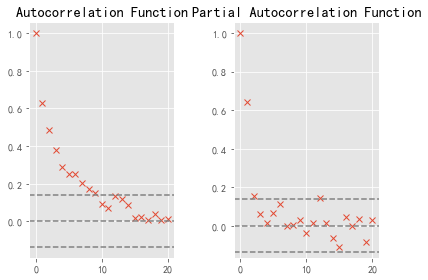

In [4]:
# 通过ACF,PACF找出ARIMA（p，d，q）模型中的p,q
ACF_PACF(data)


c:\users\yuyan\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5,1,'RSS: 12.3294')

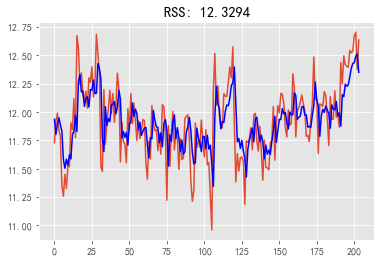

In [6]:
# 用ARIMA模型拟合并看对数情况系模拟情况
model = ARIMA(data, order=(9, 0, 3))
results_ARIMA = model.fit(disp=-1)
plt.plot(data)

plt.plot(results_ARIMA.fittedvalues, color='b')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues - data) ** 2))

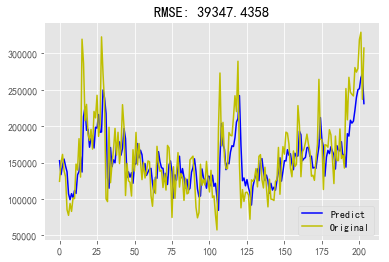

In [12]:
#实际历史数据模拟情况
k=np.exp(data)
predict_ts = results_ARIMA.predict()
log_recover = np.exp(predict_ts)
log_recover.dropna(inplace=True)
data = data[log_recover.index]
log_recover.plot(color='blue', label='Predict')
k.plot(color='y', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f' % np.sqrt(sum((log_recover - k) ** 2) / k.size))
plt.show()

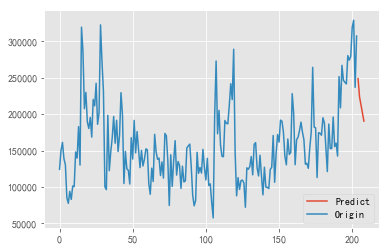

In [15]:
#拟合数据图像
results = np.exp(results_ARIMA.predict(204, 208))
results.plot(label='Predict')
k.plot(label='Origin')
plt.legend(loc='best')
plt.show()

In [16]:
#以此输出24日-28日值
np.exp(results_ARIMA.predict(204,208))

204    248680.669874
205    223628.952776
206    212744.495103
207    201486.709855
208    190364.054472
dtype: float64